In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

from collections import Counter

In [2]:
sns.set(style='whitegrid')


# Load iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names


# Put into DataFrame for convenience
df = pd.DataFrame(X, columns=feature_names)
df['species'] = pd.Categorical.from_codes(y, iris.target_names)


print('Dataset shape:', df.shape)
print(df.head())

Dataset shape: (150, 5)
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
from collections import Counter

def map_clusters_to_labels(cluster_labels, true_labels):
    """Map each cluster id to the most common true label inside it."""
    mapping = {}
    for cluster in np.unique(cluster_labels):
        cluster_int = int(cluster)  # convert np.int32 -> int
        mask = cluster_labels == cluster
        if mask.sum() == 0:
            mapping[cluster_int] = -1
            continue
        most_common = Counter(true_labels[mask]).most_common(1)[0][0]
        mapping[cluster_int] = most_common
    # Create predicted labels with int() cast for lookup safety
    predicted = np.array([mapping[int(c)] for c in cluster_labels])
    return predicted, mapping


Adjusted Rand Index (KMeans k=3): 0.6201
Cluster -> species mapping (KMeans): {0: np.int64(1), 1: np.int64(0), 2: np.int64(2)}


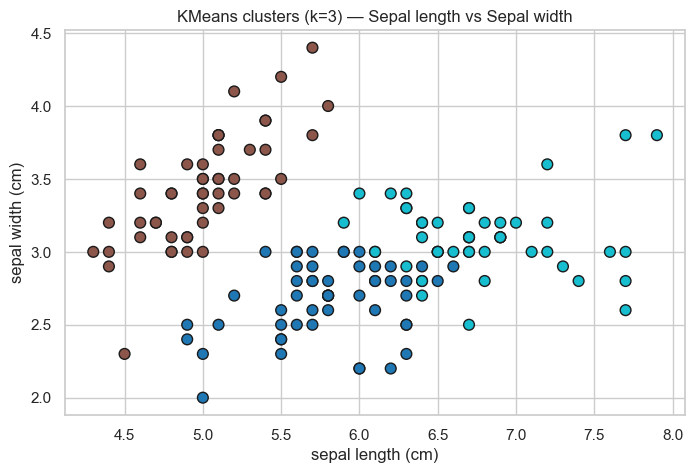

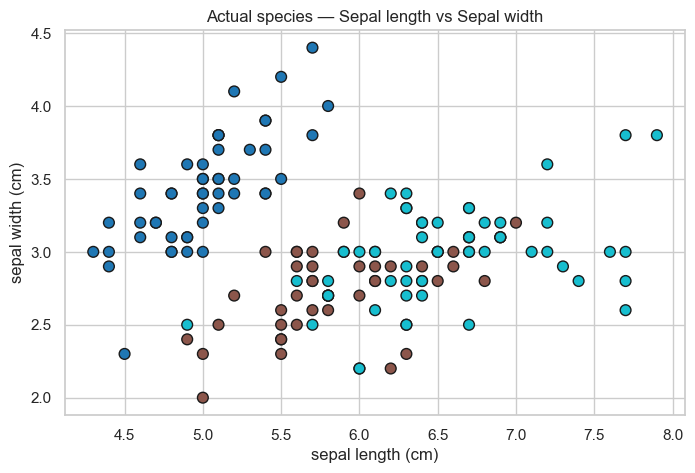

In [11]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)


# Map cluster ids to labels to evaluate
pred_labels_kmeans, mapping_kmeans = map_clusters_to_labels(clusters_kmeans, y)
ari_kmeans = adjusted_rand_score(y, clusters_kmeans)
print('Adjusted Rand Index (KMeans k=3):', round(ari_kmeans, 4))
print('Cluster -> species mapping (KMeans):', mapping_kmeans)


# Scatter plot using sepal length (0) and sepal width (1)
plt.figure(figsize=(8,5))
plt.scatter(X[:,0], X[:,1], c=clusters_kmeans, cmap='tab10', s=60, edgecolor='k')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('KMeans clusters (k=3) — Sepal length vs Sepal width')
plt.show()


# Also compare to actual species scatter (for visual reference)
plt.figure(figsize=(8,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='tab10', s=60, edgecolor='k')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Actual species — Sepal length vs Sepal width')
plt.show()

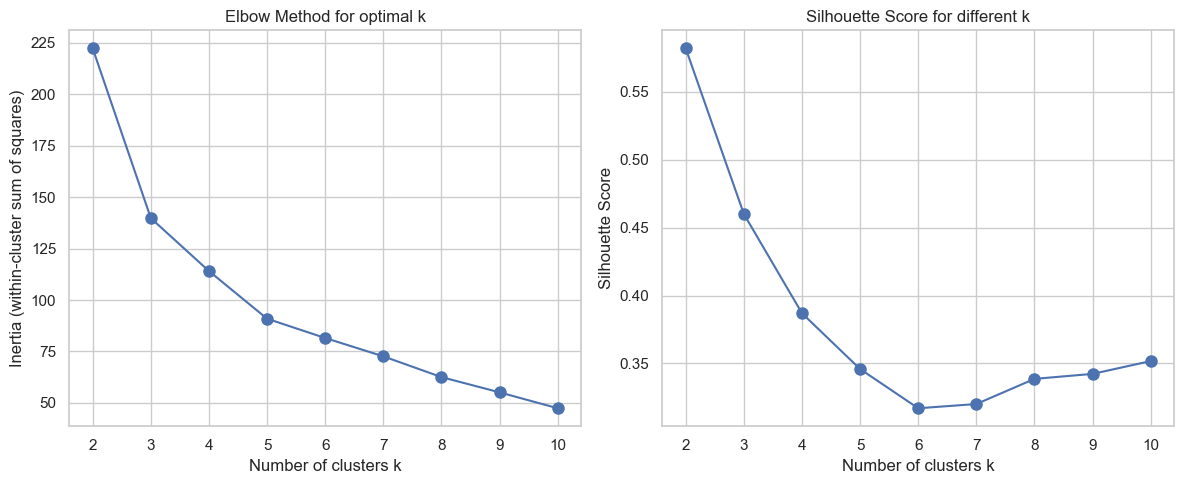

Silhouette scores by k:
k=2: silhouette=0.5818
k=3: silhouette=0.4599
k=4: silhouette=0.3869
k=5: silhouette=0.3459
k=6: silhouette=0.3171
k=7: silhouette=0.3202
k=8: silhouette=0.3387
k=9: silhouette=0.3424
k=10: silhouette=0.3518


In [13]:
inertia = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot Elbow
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'o-', markersize=8)
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for optimal k')

# Plot Silhouette
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, 'o-', markersize=8)
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different k')

plt.tight_layout()
plt.show()

print('Silhouette scores by k:')
for k, s in zip(K_range, sil_scores):
    print(f'k={k}: silhouette={s:.4f}')


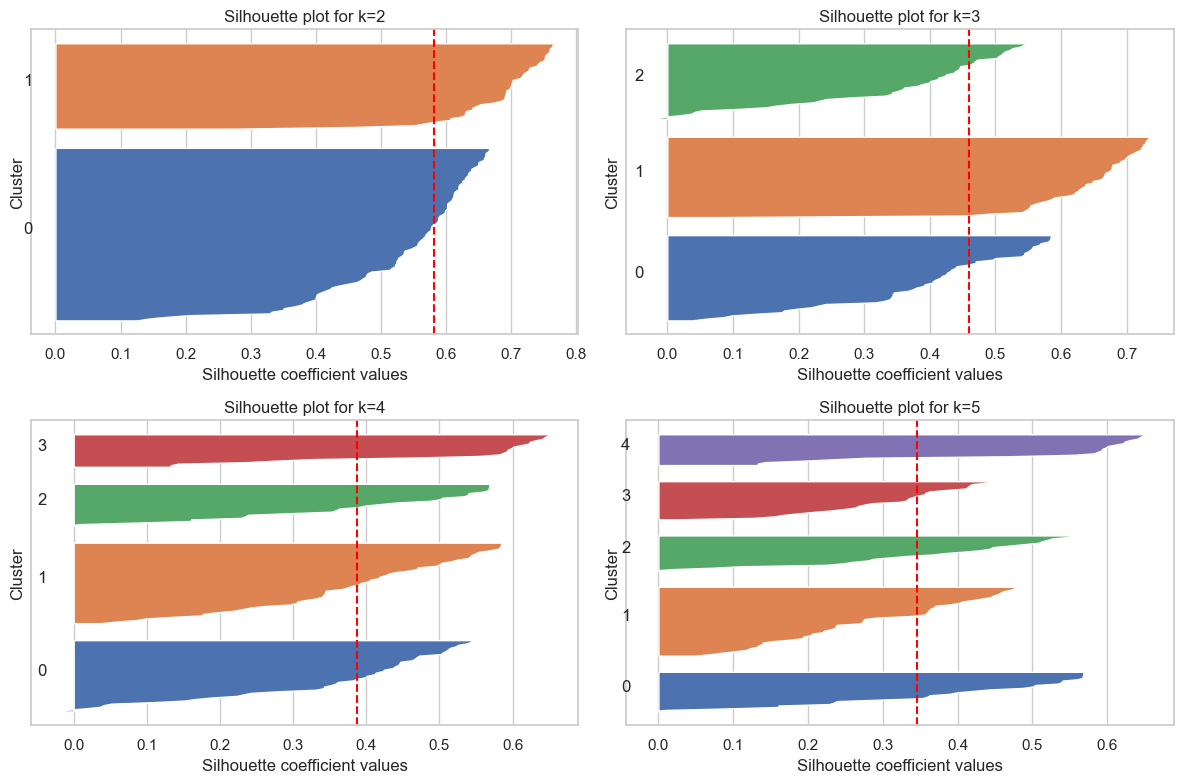

In [15]:
# Function to plot silhouette for a specific k
from sklearn.metrics import silhouette_samples

def plot_silhouette(X, labels, k, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,4))
    sample_silhouette_values = silhouette_samples(X, labels)
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_xlabel('Silhouette coefficient values')
    ax.set_ylabel('Cluster')
    ax.axvline(x=np.mean(sample_silhouette_values), color='red', linestyle='--')
    ax.set_yticks([])
    ax.set_title(f'Silhouette plot for k={k}')

plt.figure(figsize=(12,8))
for idx, k in enumerate([2,3,4,5], 1):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    ax = plt.subplot(2,2,idx)
    plot_silhouette(X_scaled, labels, k, ax=ax)

plt.tight_layout()
plt.show()


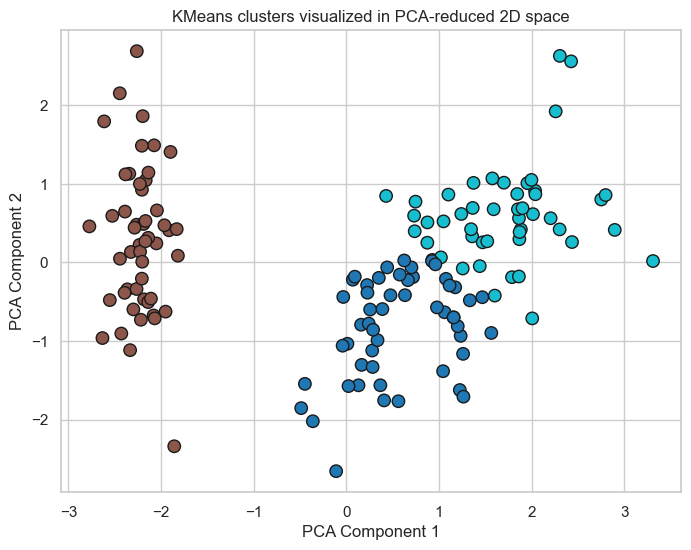

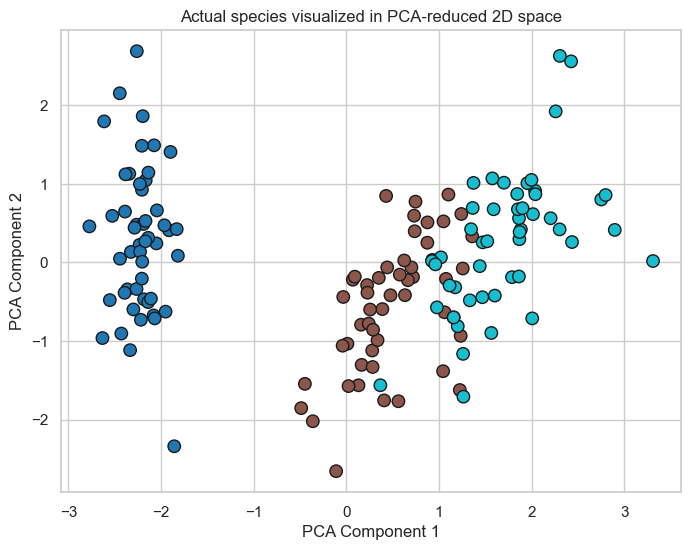

In [16]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)


# Fit KMeans with k=3 (best known for iris)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_pca = kmeans.fit_predict(X_pca)


plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_pca, cmap='tab10', s=80, edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans clusters visualized in PCA-reduced 2D space')
plt.show()


# Also show ground truth in PCA space
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='tab10', s=80, edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Actual species visualized in PCA-reduced 2D space')
plt.show()

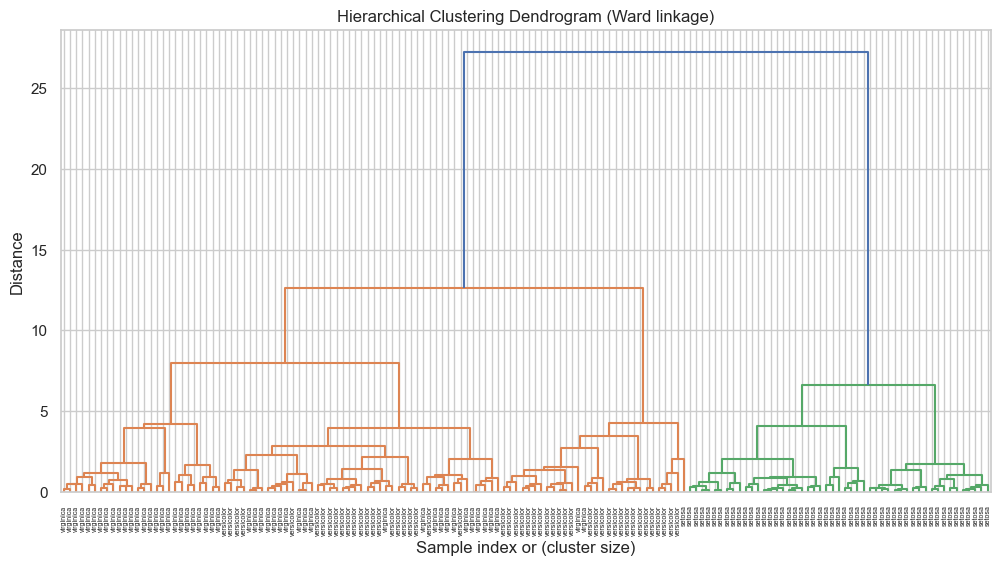

In [17]:

linked = linkage(X_scaled, method='ward')


plt.figure(figsize=(12, 6))
dendrogram(linked,
labels=iris.target_names[y],
orientation='top',
distance_sort='descending',
show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (Ward linkage)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

Adjusted Rand Index (Agglomerative k=3): 0.6153
Cluster -> species mapping (Agglomerative): {0: np.int64(2), 1: np.int64(0), 2: np.int64(1)}


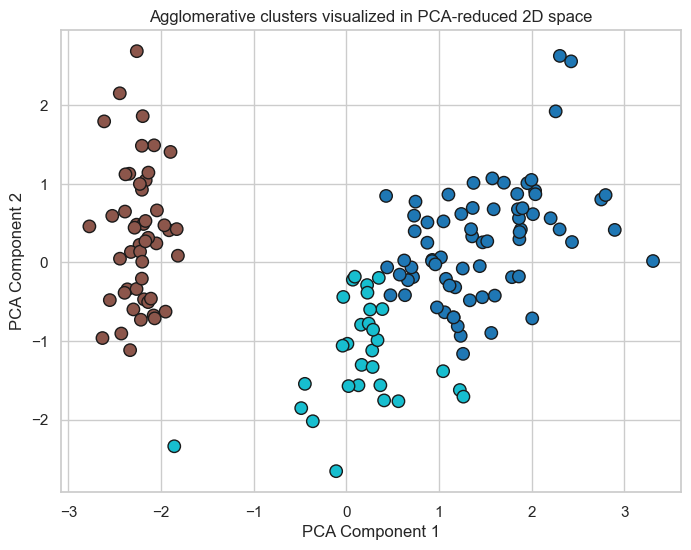

In [18]:
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters_agg = agg.fit_predict(X_scaled)


pred_labels_agg, mapping_agg = map_clusters_to_labels(clusters_agg, y)
ari_agg = adjusted_rand_score(y, clusters_agg)
print('Adjusted Rand Index (Agglomerative k=3):', round(ari_agg, 4))
print('Cluster -> species mapping (Agglomerative):', mapping_agg)


# Visualize Agglomerative clustering in PCA space
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_agg, cmap='tab10', s=80, edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Agglomerative clusters visualized in PCA-reduced 2D space')
plt.show()

In [19]:
sil_kmeans = silhouette_score(X_scaled, clusters_kmeans)
sil_agg = silhouette_score(X_scaled, clusters_agg)


print(f'KMeans (k=3) silhouette: {sil_kmeans:.4f}, ARI: {ari_kmeans:.4f}')
print(f'Agglomerative (k=3) silhouette: {sil_agg:.4f}, ARI: {ari_agg:.4f}')


# Confusion matrices (after mapping cluster ids to species labels)
cm_kmeans = confusion_matrix(y, pred_labels_kmeans)
cm_agg = confusion_matrix(y, pred_labels_agg)


print('\nConfusion matrix (true species rows, predicted by KMeans columns):\n', cm_kmeans)
print('\nConfusion matrix (true species rows, predicted by Agglomerative columns):\n', cm_agg)

KMeans (k=3) silhouette: 0.4599, ARI: 0.6201
Agglomerative (k=3) silhouette: 0.4467, ARI: 0.6153

Confusion matrix (true species rows, predicted by KMeans columns):
 [[50  0  0]
 [ 0 39 11]
 [ 0 14 36]]

Confusion matrix (true species rows, predicted by Agglomerative columns):
 [[49  1  0]
 [ 0 27 23]
 [ 0  2 48]]


#### 
Conclusions and comparison:


- KMeans:
Strengths: Fast, works well when clusters are spherical and similar size. For Iris, it finds three clusters that largely correspond to species, especially separating setosa.
Weaknesses: Assumes convex clusters and equal variance; sensitive to initialization (we used multiple inits) and to feature scaling.


- Agglomerative Hierarchical Clustering:
Strengths: Does not require specifying a center; produces a dendrogram that helps choose the number of clusters; can capture some non-spherical cluster shapes depending on linkage.
Weaknesses: More computationally expensive for large datasets; linkage choice affects results; no internal re-assignment of points (no iterative update like KMeans).


Based on ARI and silhouette score in this run both algorithms give similar performance on Iris. KMeans is typically preferred for speed and simplicity, while hierarchical methods are preferred when you want a full tree/dendrogram and interpretability of merges.


Saved kmeans_pca_scatter.png


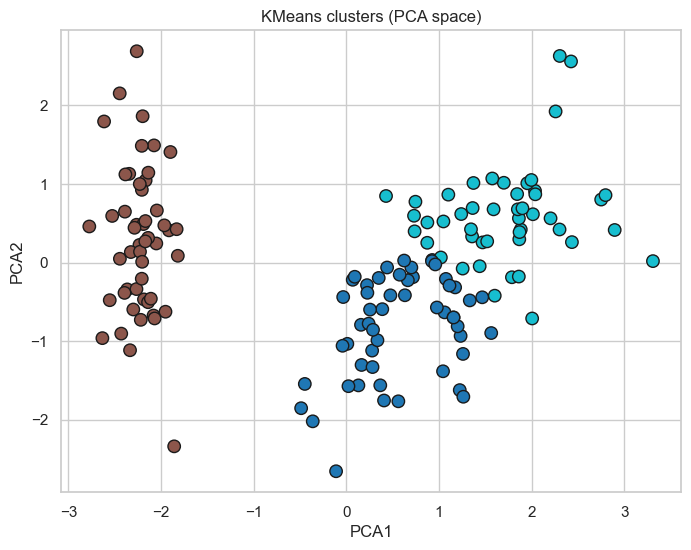

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_pca, cmap='tab10', s=80, edgecolor='k')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('KMeans clusters (PCA space)')
plt.savefig('kmeans_pca_scatter.png', dpi=200, bbox_inches='tight')
print('Saved kmeans_pca_scatter.png')